In [1]:
import argparse
import random
import os
import subprocess
import shutil

from PIL import Image
from huggingface_hub import login
from utils import MAX_LENGTH, prepare_model_and_tokenizer
from visual_utils.parser import CADparser, write_obj_sample
from IPython.display import clear_output

/home/v-wangruiyu/miniconda3/envs/cdfs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initializing model and arguments

In [49]:
parser = argparse.ArgumentParser()
# parser.add_argument("--model-name", type=str, default="llama3")
parser.add_argument("--device-map", type=str, default='auto')
parser.add_argument("--lora-rank", type=int, default=32)
parser.add_argument("--lora-alpha", type=int, default=32)
parser.add_argument("--lora-dropout", type=float, default=0.05)
parser.add_argument("--pretrained-path", type=str, required=True)
parser.add_argument("--top-p", type=float, default=0.9)
parser.add_argument("--temperature", type=float, default=0.9)

arguments = ['--pretrained-path', '/home/v-wangruiyu/repos/CADFusion/exp/model_ckpt/CADFusion_v1_1', '--temperature', '0.3']
args = parser.parse_args(arguments)

In [ ]:
login() # put your own hf token to access llama
random.seed(0)
model, tokenizer = prepare_model_and_tokenizer(args)
model.eval()
clear_output()

### Custom prompting

In [180]:
description = input("Please input a description of a 3D shape: ")
# description = 'The 3D shape is a cylinder.'

prompt = 'Below is a description of a 3D shape:\n'
prompt += description
prompt += '\nGenerate a Computer-Aided Design(CAD) command sequence of the 3D shape:\n'

### Inference and rendering

#### Model Inference

In [181]:
batch = tokenizer(
    prompt,
    return_tensors="pt",
)
batch = {k: v.cuda() for k, v in batch.items()}

generate_ids = model.generate(
    **batch,
    do_sample=True,
    max_new_tokens=MAX_LENGTH,
    temperature=args.temperature,
    top_p=args.top_p,
    repetition_penalty=1.3,
)

gen_strs = tokenizer.batch_decode(
    generate_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False,
)
gen_strs = gen_strs[0][len(prompt):]
gen_strs

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'circle,31,53,31,9,53,31,9,31 <curve_end> <loop_end> circle,31,51,31,11,51,31,11,31 <curve_end> <loop_end> <face_end> circle,31,51,31,11,51,31,11,31 <curve_end> <loop_end> <face_end> <sketch_end> add,0,62,31,31,31,1,0,0,0,0,1,0,-1,0,7,31,31 <extrude_end>'

#### Render .obj file

In [182]:
out_path = 'visual_cache/gen_obj'
# remove the existing output directory if it exists
if os.path.exists(out_path):
    shutil.rmtree(out_path)
# create the output directory
os.makedirs(out_path, exist_ok=True)

cad_parser = CADparser(bit=6)
parsed_data = cad_parser.perform(gen_strs)
write_obj_sample(out_path, parsed_data)

#### Render .step, .stl, .ply files
N.B. if the Statistics on Transfer logs do not show up, the model may not have produced renderable outputs. Re-run the inference or change your prompt to see if it gets better results. 

In [184]:
out_path = os.path.abspath(out_path)
py_path = os.path.abspath('../rendering_utils/parser_visual.py')
subprocess.run(['python3', py_path, '--data_folder', out_path, '--single-file'])
py_path = os.path.abspath('../rendering_utils/ptl_sampler.py')
subprocess.run(['python3', py_path, '--in_dir', out_path, '--out_dir', 'ptl', '--single-file'])
# clear_output()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : /home/v-wangruiyu/repos/CADFusion/src/test/visual_cache/gen_obj/gen_obj_001_final.step(273 ents)  Write  Done


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CompletedProcess(args=['python3', '/home/v-wangruiyu/repos/CADFusion/src/rendering_utils/ptl_sampler.py', '--in_dir', '/home/v-wangruiyu/repos/CADFusion/src/test/visual_cache/gen_obj', '--out_dir', 'ptl', '--single-file'], returncode=0)

#### Image rendering

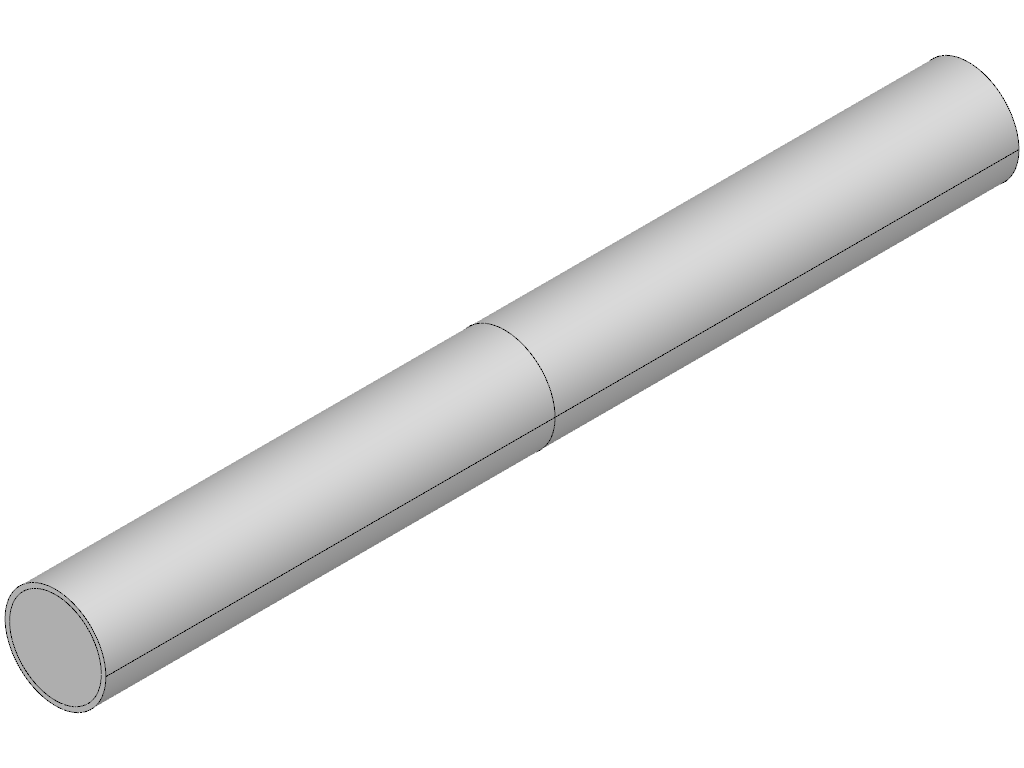

In [185]:
visual_obj_path = 'visual_cache'
output_figure_path = 'visual_cache/figures'
if os.path.exists(output_figure_path):
    shutil.rmtree(output_figure_path)
py_path = os.path.abspath('../rendering_utils/img_renderer.py')
os.makedirs(output_figure_path, exist_ok=True)
try:
    xvfb_process = subprocess.Popen(
        ["Xvfb", ":99", "-screen", "0", "640x480x24"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    print("Xvfb started in the background.")
except FileNotFoundError:
    print("Error: Xvfb not found. Please ensure it is installed and in your system's PATH.")

os.environ['DISPLAY'] = ':99'
try:
    subprocess.run(
        ['python3', py_path, '--input_dir', visual_obj_path, '--output_dir', output_figure_path]
    )
    print("Rendering script completed successfully.")
finally:
    if xvfb_process.poll() is None: # Check if Xvfb is still running
        xvfb_process.terminate()
        print("Xvfb terminated.")
    else:
        print("Xvfb already exited.")
        
del os.environ['DISPLAY']
clear_output()

input_image_path = os.path.join(output_figure_path, 'gen_ob.png')
if os.path.exists(input_image_path):
    img = Image.open(input_image_path)
    img.show()
else:
    print(f"{input_image_path} does not exist.")

#### Files retrieval
By default, the produced step, stl, obj and ply files are stored under the visual_cache folder. You can save them to your custom places for further use. Do not put them in the cache folder as they will be deleted after the next run.